# Dissertation Code - B151410

## Part 2 - Finding Transition Probabilities

This section of the code handles generation of transition probabilities for the microsimulation model and the actual implementation of the actual microsimulation model using the synthetic data generated in the previous section. Similar to the previous section, the code was published on Github and can be found at https://github.com/rohankumarPfE/B151410_Dissertation

This model is summarized and critically appraised in more detail in Section 4.2 - 'Spatial Microsimulation Model'. The results were reported in Section 6.2 - 'Microsimulation'

In [38]:
#importing relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#reading synthetic data that was generated previously
data = pd.read_csv("/Users/rohankumar/ProgrammingForEconomics/Synthetic Data copy.csv")

In [39]:
#initial parameters
n_individuals = len(data.index)
states = {'susceptible', 'exposed', 'infected', 'recovered'}
n_states = len(states)

# making each column into a NumPy array that can be called later - easier to deal with and provides flexibility in later code
def dataframe_to_array(data):
    arrays={}
    for col in data.columns:
        arrays[col] = np.array(data[col])
    return arrays
data_dict = dataframe_to_array(data)

# some columns have both string and numeric values and must be converted where possible
columns_to_retype = ['HrWkUS', 'LeisNum1', 'LeisNum2', 'LeisNum5', 'LeisNum6', 'LeisNum7', 'LeisNum8']

# this function is to deal with the mixed data columns, many of the cells have 'Item not applicable' written in a String format
# this code converts any numeric values to Integer types and assigns the remaining values to 0
def convert_to_numeric(value):
    try:
        return int(value)
    except ValueError:
        return 0

# calling the previous function for all relevant columns
for i in columns_to_retype:
    data[i] = data[i].apply(convert_to_numeric)

This block of code calculates the COVID likelihood multipliers from different actions and then combines that information with the behaviour patterns from the synthetic data. In effect, this uses heavily detailed data to analyze each specific individual's risk of moving from the non-infected Susceptible group, to the infected Exposed group. The base covid_rate refers to the possibility of getting COVID-19 from some activity not listed as a variable. An example may be people who are infected as a reuslt of their children going to school. The base rate of 1% was chosen to simplify the calculations and provide an appropriate estimate. 

The block of code immediately after modifies these state-transition probabilities in the case of a COVID-19 lockdown with pre-defined adherence patterns.

In [73]:
# rate of covid if no extra risk factors
covid_rate = 0.01

# creating behavioural probability function by processing the dataframe
def prob_multiplier_work(data_dict):
    
    # initializing lists to hold the individual prob multipliers
    wrking_multiplier = []
    stat_multiplier = []
    dsic_multiplier = []
    HrWkUS_multiplier = []
    total_work_multiplier = [] # list to hold all-inclusive multiplier
    
    # iterating through the first four columns in the dataframe (columns related to work patterns)
    for col_name in data.columns[1:5]:
        col_data = data[col_name]
        
        # for each of the four work pattern characteristics, the function creates a multiplier if the person has a particular characteristic
        # these multipliers (can also be interpreted as odds ratios) are sourced from literature and are in Appendix A
        if col_name == "Wrking":
            for value in col_data:
                if value == "No":
                    wrking_multiplier.append(0)
                else:
                    wrking_multiplier.append(1)
        
        # work status - either self-employed, not-working, or employee
        # self-employed individuals tend to have smaller businesss, with less people, this odds ratio change accounts for this
        if col_name == "Stat":
            for value in col_data:
                if value == "Self-employed":
                    stat_multiplier.append(0.5)
                else: 
                    stat_multiplier.append(1)
        
        # this conditional block refers to the sectors and accounts for the increased risk for certain health professions
        # health workers, educational professionals, and customer service professionals would be at increased risk
        if col_name == "dsic":
            for value in col_data:
                if value == "Public admin, education and health":
                    dsic_multiplier.append(1.7)
                elif value == "Distribution, hotels and restaurants": 
                    dsic_multiplier.append(1.6)
                elif value == "Other services": 
                    dsic_multiplier.append(1.6)
                else:
                    dsic_multiplier.append(1)
        
        # hours worked per week - intuition is simple, more hours per week is more interaction with others and more COVID risk
        # the linear correlation is supported in the literature
        if col_name == "HrWkUS":
            for value in col_data:
                if value > 40:
                    HrWkUS_multiplier.append(1*(value-40)/40)
                elif value < 40: 
                    HrWkUS_multiplier.append(1*(40-value)/40)
                else:
                    HrWkUS_multiplier.append(1)
    
    # combining AORs to create a combined probability multiplier for all work-related risk factors           
    for i in range(len(wrking_multiplier)):
        total_work_multiplier.append(wrking_multiplier[i]*stat_multiplier[i]*dsic_multiplier[i]*HrWkUS_multiplier[i])
    
    return total_work_multiplier

# second probability multiplier function - this one refers to household characteristics
def prob_multiplier_household(data_dict):
    household_multiplier = []
    
    # medical literature found higher risk of COVID for individuals living alone, this is likely not causal but requires correction
    for value in data['DVHsize']:
        if value == 1:
            household_multiplier.append(1)
        else:
            household_multiplier.append(0.88)
    
    return household_multiplier

# third probability multiplier function - this one refers to leisure behavior patterns - most typical leisure activities are social and have higher risks
def prob_multiplier_leisure(data_dict):
    cinema=[]
    theatre=[]
    cultural=[]
    sport=[]
    eating=[]
    entertaining=[]
    total_leisure=[]
    
    # all leisure-based estimations of increased risk come from government health information
    for col_name in data.columns[0:20]:
        col_data = data[col_name]
        
        # visiting cinema
        if col_name == "LeisNum1":
            for value in col_data:
                if value == 0:
                    cinema.append(1)
                else:
                    cinema.append(1.09*value/4)
        
        # visiting theatre
        if col_name == "LeisNum2":
            for value in col_data:
                if value == 0:
                    theatre.append(1)
                else: 
                    theatre.append(1.09*value/4)
        
        # visiting cultural or historical sites
        if col_name == "LeisNum5":
            for value in col_data:
                if value == 0:
                    cultural.append(1)
                else: 
                    cultural.append(1.09*value/4)
        
        # watching sports match/game in a stadium            
        if col_name == "LeisNum6":
            for value in col_data:
                if value == 0:
                    sport.append(1)
                else: 
                    sport.append(1.09*value/4)
        
        # eating with friends in a restaurant - typically indoors, hence higher risk
        if col_name == "LeisNum7":
            for value in col_data:
                if value == 0:
                    eating.append(1)
                else: 
                    eating.append(1.28*value)
        
        # entertaining friends/family at house
        if col_name == "LeisNum8":
            for value in col_data:
                if value == 0:
                    entertaining.append(1)
                else: 
                    entertaining.append(1.27*value)
                    
    for i in range(len(entertaining)):
        total_leisure.append(cinema[i]*theatre[i]*cultural[i]*sport[i]*eating[i]*entertaining[i])
    
    return total_leisure

# final behavioural multiplier - physical activities
def prob_multiplier_physical(data_dict):
    
    # initializing lists to hold the individual prob multipliers
    gym = []
    teamsport = []
    total_physical = [] # list to hold all-inclusive multiplier
    
    # iterating through the first four columns in the dataframe (columns related to work patterns)
    for col_name in data.columns[0:20]:
        col_data = data[col_name]
        
        # for each of the four work pattern characteristics, the function creates a multiplier if the person has a particular characteristic
        # these multipliers (can also be interpreted as odds ratios) are sourced from literature and are in Appendix A
        if col_name == "KeepFit":
            for value in col_data:
                if value == "Yes":
                    gym.append(1.06)
                else:
                    gym.append(1)
        
        if col_name == "TeamGame":
            for value in col_data:
                if value == "Yes":
                    teamsport.append(1.36)
                else: 
                    teamsport.append(1)
                    
    for i in range(len(teamsport)):
        total_physical.append(gym[i]*teamsport[i])
    
    return total_physical

# all the multipliers were stored in lists, transferring them to arrays making calculations easier and enables multiplication/manipulation
work = np.array(prob_multiplier_work(data_dict))
household = np.array(prob_multiplier_household(data_dict))
leisure = np.array(prob_multiplier_leisure(data_dict))
physical = np.array(prob_multiplier_physical(data_dict))

# initialize and fill list to hold the likelihood of getting COVID based on 13 risk behaviours
covid_likelihood = []
for i in range(0,1000):
    covid_likelihood.append((work[i]*household[i]*leisure[i]*physical[i])*covid_rate)


In [76]:
# Behavioural multipliers in Scenario 2 - WITH LOCKDOWN

# justification for the analysis is also in Section 4.2, Results explained in Section 6.2

# assumes 3% non-adherence, but otherwise perfect adherence to lack of leisure/physical
leisure_LD = leisure*0.05
physical_LD = physical*0.05

# households did not reorganize as a result of lockdown - means that household characteristics are constant 
household_LD = household

# assuming that only selected professions can work from home means that some work pattern risk decreases significantly and other's remain constant
# complicating factors in work patterns means that it is efficient to define a separate function
def work_LD_multi(data_dict):
    
    # initializing lists to hold the individual prob multipliers
    wrking_multiplier = []
    stat_multiplier = []
    dsic_multiplier = []
    HrWkUS_multiplier = []
    LD_work_multiplier = [] # list to hold all-inclusive multiplier
    
    # iterating through the first four columns in the dataframe (columns related to work patterns)
    for col_name in data.columns[1:5]:
        col_data = data[col_name]
        
        # for each of the four work pattern characteristics, the function creates a multiplier if the person has a particular characteristic
        # these multipliers (can also be interpreted as odds ratios) are sourced from literature and are in Appendix A
        if col_name == "Wrking":
            for value in col_data:
                if value == "No":
                    wrking_multiplier.append(0)
                else:
                    wrking_multiplier.append(1)
        
        if col_name == "Stat":
            for value in col_data:
                if value == "Self-employed":
                    stat_multiplier.append(0.5)
                else: 
                    stat_multiplier.append(1)
        
        # slightly modified higher-risk professions - these are NHS-designated as essential, meaning lower likelihood of remote work
        if col_name == "dsic":
            for value in col_data:
                if value == "Public admin, education and health":
                    dsic_multiplier.append(1.7)
                elif value == "Other services": 
                    dsic_multiplier.append(0.75)
                elif value == "Transport and communication": 
                    dsic_multiplier.append(0.75)
                elif value == "Manufacturing": 
                    dsic_multiplier.append(0.75)
                elif value == "Construction":
                    dsic_multiplier.append(0.75)
                else:
                    dsic_multiplier.append(0.05)

# remainder of this block of code is identical in intution and practice as previous block of code
        if col_name == "HrWkUS":
            for value in col_data:
                if value > 40:
                    HrWkUS_multiplier.append(1*(value-40)/40)
                elif value < 40: 
                    HrWkUS_multiplier.append(1*(40-value)/40)
                else:
                    HrWkUS_multiplier.append(1)
                    
    for i in range(len(wrking_multiplier)):
        LD_work_multiplier.append(wrking_multiplier[i]*stat_multiplier[i]*dsic_multiplier[i]*HrWkUS_multiplier[i])
    
    return LD_work_multiplier

work_LD = work_LD_multi(data_dict)

LD_covid_likelihood = []

for i in range(0,1000):
    LD_covid_likelihood.append((work_LD[i]*household_LD[i]*leisure_LD[i]*physical_LD[i])*covid_rate)

All of the previous multipliers were in relation to behavioural characteristics from the synthetic version of the UK Time Use Survey - this means that they only impact the incidence of COVID-19, not the severity or mortality. The next block of code considers the impact of pre-existing health issues on the COVID experience, i.e. whether patients are symptomatic, asymptomatic, and whether they will recover. In terms of the SEIR model, this is the likelihoods of moving from Exposed to Infected to Recovered, and the severity of their experience. The remaining work uses a baseline of 40.50% of patients having asymptomatic COVID-19, this comes directly from the existing medical literature. 


In [41]:
# initial rates of asymptomatic COVID and mortality from COVID - NOTE: these are listed as %s NOT as decimals, this enables easier operation
asymptomatic_rate = 40.5
mortality_rate = 1

# Python dict to hold the co-morbidities impacts on COVID symptomatic/mortality rates - 
# most are estimates sourced from literature, some are artificial estimates, made to simplify computation
comorbidities = {
    'Cancer': 1.8,
    'Chronic kidney disease': 2,
    'Chronic liver disease': 2.1,
    'Chronic lung disease': 4.38,
    'Cystic fibrosis': 2.1,
    'Dementia': 2.1,
    'Diabetes': 2.34,
    'Disability': 2.1,
    'Heart conditions': 2.1,
    'HIV': 2.1,
    'Mental health': 1.5,
    'Obesity': 1.5,
    'Pregnancy': 1.2,
    'Sickle cell disease': 2.1,
    'Smoking': 1.98,
    'Solid organ or blood stem cell transplant': 2.1,
    'Stroke': 2.1,
    'Substance use disorder': 2.1
}

def initial_multi(data, comorbidities):
    # Create a list to store the updated values
    multiplier = []
    
    # Iterate through each row in the DataFrame
    for index, row in data.iterrows():
        # Iterate through each column in the row
        for column in data.columns[16::]:
            # Check if the value is 1
            if row[column] == 1:
                # Find the key in the dictionary with the same name as the column
                key = column
                # Append the value from the dictionary to the list
                multiplier.append([index, comorbidities.get(key)])
    
    return multiplier

def duplicates(data, multiplier):
    # Create a dictionary to store the data
    data_dict = {item[0]: item[1] for item in data}
    
    # Iterate through the multiplier list
    for item in multiplier:
        # Extract the first value from the item
        key = item[0]
        # Check if the key is present in the data dictionary
        if key in data_dict:
            # Multiply the second value of the item with the corresponding value in the data dictionary
            item[1] *= data_dict[key]
    
    # Create a dictionary to store the updated items with unique first values
    updated_dict = {}
    for item in multiplier:
        # Extract the first value from the item
        key = item[0]
        # Check if the key is already present in the updated_dict
        if key in updated_dict:
            # Multiply the second value of the item with the corresponding value in the updated_dict
            updated_dict[key] *= item[1]
        else:
            # If the key is not present, add the item to the updated_dict
            updated_dict[key] = item[1]
    
    # Create a list to store the updated items
    updated_multiplier = [[key, value] for key, value in updated_dict.items()]
    
    return updated_multiplier

def fill(lst):
    # Create a set to store the numbers already present in the list
    present_numbers = set()
    
    # Iterate through the sublists in the list
    for sublist in lst:
        # Extract the first number from the sublist
        num = sublist[0]
        # Add the number to the set of present numbers
        present_numbers.add(num)
    
    # Create a list to store the new sublists
    new_sublists = []
    
    # Iterate through all numbers between 0 and 999
    for num in range(999):
        # Check if the number is not present in the list
        if num not in present_numbers:
            # Create a new sublist with the number and 1 as the second item
            new_sublist = [num, 1]
            # Append the new sublist to the list of new sublists
            new_sublists.append(new_sublist)
    
    # Concatenate the original list and the list of new sublists
    updated_list = lst + new_sublists
    
    sorted_list = sorted(updated_list, key=lambda x: x[0])
    
    return sorted_list

# nested function calls to create multiplier list, remove duplicates, fill and sort the list
multiplier = fill(duplicates(data, initial_multi(data,comorbidities)))

# initializing empty lists to hold actual probability multipliers
symptomatic = []
mortality = []

# appending the values from the multiplier multiplied by the initial symptomatic/mortality rates from the literature
for i in multiplier:
    symptomatic.append(i[1]*int((100-asymptomatic_rate)))
    mortality.append(i[1]*int(mortality_rate))

# previous code, I could not calculate the symptomatic/mortality multipliers as decimals because of Python limits
# note: this has to be run separately from for-loop above because if it is re-run without the loop, the probabilities are divided by 100 again
symptomatic = [x/100 for x in symptomatic]
mortality = [x/100 for x in mortality]

## Part 3 - Microsimulation Model

Now that we have lists with the specific individual transition probabilities for all 1000 individuals, we can build the actual microsimulation model. The next several blocks of code will do so, and will test the model. This process is summarized in Section 4.2 - 'Spatial Microsimulation Model'. The results are summarized in Section 6.2 - 'Microsimulation'. The code is also publicly published at https://github.com/rohankumarPfE/B151410_Dissertation

In [42]:
# initial parameters for the model
num_individuals = len(multiplier)
num_cycles = 100

In [70]:
# Building the Susceptible --> Exposed --> Infected --> Recovered model

# function defines process of moving individuals from susceptible to exposed - PRE-SYMPTOMATIC/LATENT PERIOD ONLY
def susceptible_exposed(covid_likelihood, num_individuals, num_cycles):
    
    # initialize list to hold indices of individuals who have been exposed
    exposed_state_count = []
    
    # loop through the cycles, building a set to hold the exposed individuals
    for i in range(num_cycles):
        moved_to_exposed = set()
        
        # sub-loop within the cycle to examine individual behaviour for each cycle
        for i in range(num_individuals):
            
            # logic is to ignore those who are already in the exposed state as they cannot go backward and continue simulating those who are susceptible
            if i in exposed_state_count:
                continue
            if np.random.rand() < covid_likelihood[i]:
                moved_to_exposed.add(i)
        
        # updating the list of indices
        exposed_state_count.extend(moved_to_exposed)
        
    return exposed_state_count

# function defines process of moving individuals from pre-symptomatic(exposed) to symptomatic
def exposed_infected(exposed_individuals, symptomatic):
    symptomatic_count = []
    
    for i in range(num_cycles):
        moved_to_symptomatic = set()
        for i in range(len(exposed_individuals)):
            if i in moved_to_symptomatic:
                continue
            if np.random.rand() < symptomatic[i]:
                moved_to_symptomatic.add(i)
    
    
    return moved_to_symptomatic  

def infected_recovered(asymptomatic_individuals, symptomatic_individuals, mortality):

    # Initialize lists to store indices of individuals who recovered
    asymptomatic_recovered_indices = asymptomatic_individuals # all individuals who are asymptomatic will recover - intuition should be clear (impossible to die with no symptoms)
    symptomatic_recovered_indices = []
    symptomatic_random_numbers = np.random.rand(len(symptomatic_individuals))

    # Update state for symptomatic individuals - slightly different process given we have mortality probabilities instead of recovery probabilities
    for index in range(len(symptomatic_individuals)):
        if symptomatic_random_numbers[index] <= (1 - mortality[symptomatic_individuals[index]]):
            # Individual has recovered
            symptomatic_recovered_indices.append(symptomatic_individuals[index])

    # Combine the lists of recovered indices for asymptomatic and symptomatic individuals
    recovered_indices = asymptomatic_recovered_indices + symptomatic_recovered_indices

    # Return the list of indices of individuals who have recovered
    return recovered_indices


In [78]:
# Scenario 1 - no lockdown - running MSM with initial transition probabilities

# running model with actual transition probabilities 
n_exposed = susceptible_exposed(covid_likelihood, num_individuals, num_cycles)
n_symptomatic = exposed_infected(n_exposed, symptomatic)
n_symptomatic = list(n_symptomatic)

# symptomatic calculation only returns symptomatic individuals, remainder are filled in by comparing with initial exposed list
n_asymptomatic = [num for num in range(len(n_exposed))]
n_asymptomatic = [num for num in n_asymptomatic if num not in n_symptomatic]
n_recovered = infected_recovered(n_asymptomatic, n_symptomatic, mortality)

# same logic as symptomatic/asymptomatic - infected_recovered function only calculates those who recover, ones left out are deceased
n_deceased = [num for num in range(len(n_symptomatic))]
n_deceased = [num for num in n_deceased if num not in n_recovered]

# final counts - Scenario 1 - no lockdown
print("NO LOCKDOWN RESULTS:")
print("The number of individuals who were infected with COVID-19 in the 100-day period were: ", len(n_exposed),'.')
print("Of those individuals, ",len(n_symptomatic)," had some symptoms, and ", len(n_asymptomatic)," had no symptoms.")
print("Of the exposed individuals ",len(n_recovered)," recovered, and ",len(n_deceased)," passed away at some point during the 100 days.")
print("The total of the recovered population includes all non-symptomatic infected individuals.")


# Scenario 2 - lockdown - running MSM with adjusted transition probabilities
# running model with actual transition probabilities - otherwise identical code to previous Scenario
n_exposed_LD = susceptible_exposed(LD_covid_likelihood, num_individuals, num_cycles)
n_symptomatic_LD = exposed_infected(n_exposed_LD, symptomatic)
n_symptomatic_LD = list(n_symptomatic_LD)
n_asymptomatic_LD = [num for num in range(len(n_exposed_LD))]
n_asymptomatic_LD = [num for num in n_asymptomatic_LD if num not in n_symptomatic_LD]
n_recovered_LD = infected_recovered(n_asymptomatic_LD, n_symptomatic_LD, mortality)
n_deceased_LD = [num for num in range(len(n_symptomatic_LD))]
n_deceased_LD = [num for num in n_deceased_LD if num not in n_recovered_LD]

# final counts - Scenario 2 - lockdown
print("LOCKDOWN RESULTS:")
print("The number of individuals who were infected with COVID-19 in the 100-day period were: ", len(n_exposed_LD),'.')
print("Of those individuals, ",len(n_symptomatic_LD)," had some symptoms, and ", len(n_asymptomatic_LD)," had no symptoms.")
print("Of the exposed individuals ",len(n_recovered_LD)," recovered, and ",len(n_deceased_LD)," passed away at some point during the 100 days.")
print("The total of the recovered population includes all non-symptomatic infected individuals.")

NO LOCKDOWN RESULTS:
The number of individuals who were infected with COVID-19 in the 100-day period were:  581 .
Of those individuals,  478  had some symptoms, and  103  had no symptoms.
Of the exposed individuals  570  recovered, and  7  passed away at some point during the 100 days.
The total of the recovered population includes all non-symptomatic infected individuals.
LOCKDOWN RESULTS:
The number of individuals who were infected with COVID-19 in the 100-day period were:  26 .
Of those individuals,  19  had some symptoms, and  7  had no symptoms.
Of the exposed individuals  25  recovered, and  1  passed away at some point during the 100 days.
The total of the recovered population includes all non-symptomatic infected individuals.


## Visualizing Results

Simple time-baased visualization to interpret the results, the written interpretation is in Section 6.2

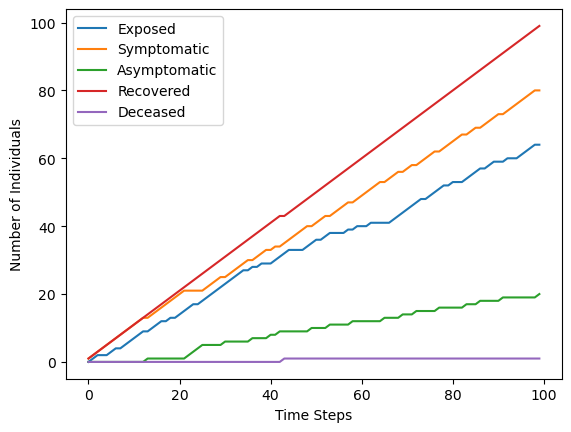

In [79]:
import matplotlib.pyplot as plt

# Building the Susceptible --> Exposed --> Infected --> Recovered model

# Function to plot individual states over time
def plot_individual_states_over_time(n_exposed, n_symptomatic, n_asymptomatic, n_recovered, n_deceased):
    # Create time steps for x-axis
    time_steps = range(num_cycles)
    
    # Create lists to store state counts at each time step
    exposed_count = []
    symptomatic_count = []
    asymptomatic_count = []
    recovered_count = []
    deceased_count = []
    
    # Count individuals in each state at each time step
    for step in time_steps:
        exposed_count.append(sum([1 for i in n_exposed if i <= step]))
        symptomatic_count.append(sum([1 for i in n_symptomatic if i <= step]))
        asymptomatic_count.append(sum([1 for i in n_asymptomatic if i <= step]))
        recovered_count.append(sum([1 for i in n_recovered if i <= step]))
        deceased_count.append(sum([1 for i in n_deceased if i <= step]))

    # Plot individual state counts over time
    plt.plot(time_steps, exposed_count, label='Exposed')
    plt.plot(time_steps, symptomatic_count, label='Symptomatic')
    plt.plot(time_steps, asymptomatic_count, label='Asymptomatic')
    plt.plot(time_steps, recovered_count, label='Recovered')
    plt.plot(time_steps, deceased_count, label='Deceased')
    
    # Add labels and legend
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Individuals')
    plt.legend()
    
    # Show the plot
    plt.show()

# Plot individual states over time
plot_individual_states_over_time(n_exposed, n_symptomatic, n_asymptomatic, n_recovered, n_deceased)
